In [1]:
import networkx as nx
from openqaoa.problems import Knapsack

knapsack_prob = Knapsack(values=[4, 1, 4, 2, 2],weights=[4, 2, 4, 1, 3],weight_capacity=7,penalty=8)
print(knapsack_prob.problem_instance)
knapsack_qubo = knapsack_prob.qubo
knapsack_hamiltonian = knapsack_qubo.hamiltonian

{'problem_type': 'knapsack', 'values': [4, 1, 4, 2, 2], 'weights': [4, 2, 4, 1, 3], 'weight_capacity': 7, 'penalty': 8, 'n_items': 5}


In [2]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.05)

In [4]:
from tqdm import tqdm
from openqaoa.backends import create_device
from openqaoa import QAOA
from openqaoa.utilities import ground_state_hamiltonian
import matplotlib.pyplot as plt
import json


#no noise
q1 = QAOA()
#qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
qiskit_device = create_device(location='ibmq', name='ibmq_qasm_simulator')
q1.set_device(qiskit_device)
q1.set_circuit_properties(p=4, param_type='standard', init_type='rand', mixer_hamiltonian='x')
q1.set_backend_properties(n_shots=5000, seed_simulator=1)
q1.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,
optimization_progress=True, cost_progress=True, parameter_log=True)
q1.compile(knapsack_qubo)
q1.optimize()
correct_solution1 = ground_state_hamiltonian(q1.cost_hamil)
print(correct_solution1)
opt_results1 = q1.result


#noise
q2 = QAOA()
#qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
qiskit_device = create_device(location='ibmq', name='ibmq_qasm_simulator')
q2.set_device(qiskit_device)
q2.set_circuit_properties(p=4, param_type='standard', init_type='rand', mixer_hamiltonian='x')
q2.set_backend_properties(n_shots=5000, seed_simulator=1,noise_model=noise_model)
q2.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,
optimization_progress=True, cost_progress=True, parameter_log=True)
q2.compile(knapsack_qubo)
q2.optimize()
correct_solution2 = ground_state_hamiltonian(q2.cost_hamil)
print(correct_solution1)
opt_results2 = q2.result

(-7.0, ['00011010', '00001110'])
(-7.0, ['00011010', '00001110'])


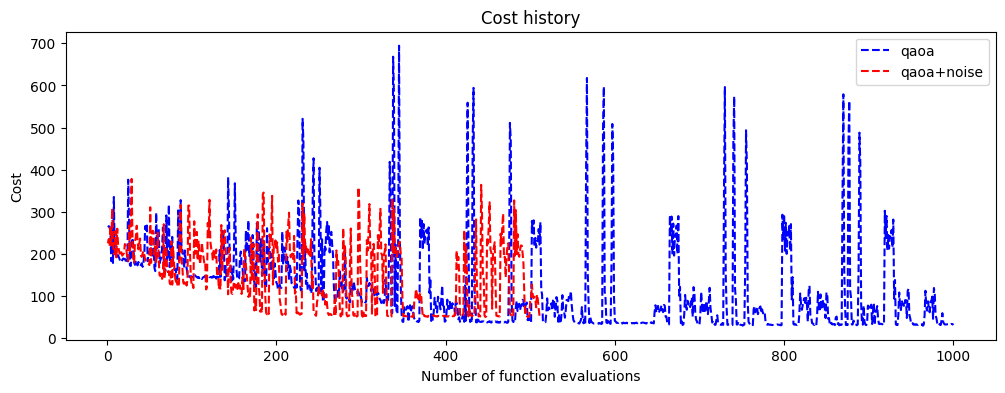

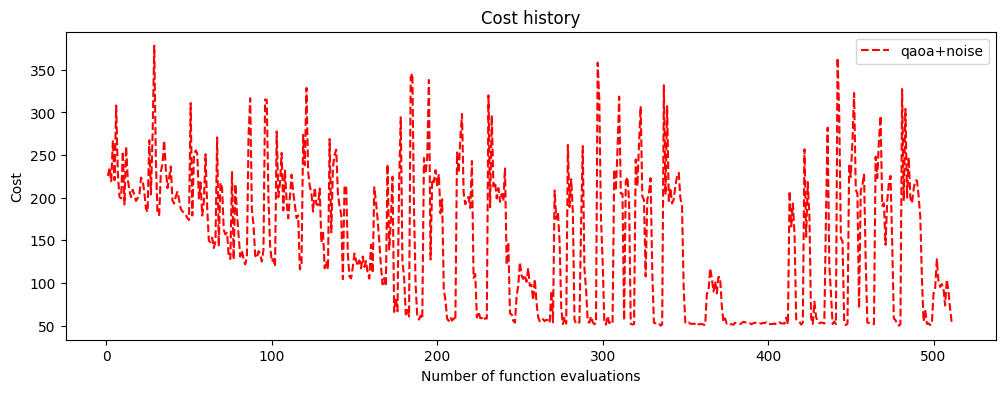

In [8]:

fig, ax = plt.subplots(figsize=(12,4))
opt_results1.plot_cost(color='blue',label='qaoa',ax=ax)
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
plt.savefig("prob1_4-standard-rand-x-Powell_qaoanoise.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(12,4))
opt_results2.plot_cost(color='red',label='qaoa+noise',ax=ax)
plt.savefig("prob1_4-standard-rand-x-Powell_noise.png", bbox_inches='tight')
